## import needed libraries

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import gc
import lightgbm as lgb
import time
from sklearn.metrics import r2_score
%matplotlib inline
sns.set()


## load data

In [2]:
!unzip /content/sales_train_validation.csv.zip
!unzip /content/sell_prices.csv.zip

Archive:  /content/sales_train_validation.csv.zip
  inflating: sales_train_validation.csv  
Archive:  /content/sell_prices.csv.zip
  inflating: sell_prices.csv         


In [3]:
INPUT_DIR = '/content/'
calendar_df = pd.read_csv(f"{INPUT_DIR}/calendar.csv")
sell_prices_df = pd.read_csv(f"{INPUT_DIR}/sell_prices.csv")
sales_data_df = pd.read_csv(f"{INPUT_DIR}/sales_train_validation.csv")

In [3]:
# read calendar dataset
calendar_df.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [4]:
sell_prices_df.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [5]:
sales_data_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [13]:
print("shape of calendar_df: ",calendar_df.shape)
print("shape of sell_prices_df: ",sell_prices_df.shape)
print("shape of sales_data_df: ",sales_data_df.shape)


shape of calendar_df:  (1969, 14)
shape of sell_prices_df:  (6841121, 5)
shape of sales_data_df:  (30490, 1919)


In [14]:
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1969 non-null   datetime64[ns]
 1   wm_yr_wk      1969 non-null   int16         
 2   weekday       1969 non-null   category      
 3   wday          1969 non-null   int8          
 4   month         1969 non-null   int8          
 5   year          1969 non-null   int16         
 6   d             1969 non-null   category      
 7   event_name_1  162 non-null    category      
 8   event_type_1  162 non-null    category      
 9   event_name_2  5 non-null      category      
 10  event_type_2  5 non-null      category      
 11  snap_CA       1969 non-null   int8          
 12  snap_TX       1969 non-null   int8          
 13  snap_WI       1969 non-null   int8          
dtypes: category(6), datetime64[ns](1), int16(2), int8(5)
memory usage: 128.3 KB


In [18]:
calendar_df.describe()

,wm_yr_wk,wday,month,year,snap_CA,snap_TX,snap_WI
count,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000
mean,11347.086338,3.997461,6.325546,2013.288471,0.330117,0.330117,0.330117
std,155.277043,2.001141,3.416864,1.580198,0.470374,0.470374,0.470374
min,11101.000000,1.000000,1.000000,2011.000000,0.000000,0.000000,0.000000
25%,11219.000000,2.000000,3.000000,2012.000000,0.000000,0.000000,0.000000
50%,11337.000000,4.000000,6.000000,2013.000000,0.000000,0.000000,0.000000
75%,11502.000000,6.000000,9.000000,2015.000000,1.000000,1.000000,1.000000
max,11621.000000,7.000000,12.000000,2016.000000,1.000000,1.000000,1.000000


In [21]:
calendar_df.isnull().sum()


date               0
wm_yr_wk           0
weekday            0
wday               0
month              0
year               0
d                  0
event_name_1    1807
event_type_1    1807
event_name_2    1964
event_type_2    1964
snap_CA            0
snap_TX            0
snap_WI            0
dtype: int64

In [15]:
sales_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: category(6), int16(1306), int8(607)
memory usage: 95.2 MB


In [19]:
sales_data_df.describe()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
count,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,...,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000
mean,1.070220,1.041292,0.780026,0.833454,0.627944,0.958052,0.918662,1.244080,1.073663,0.838701,...,1.370581,1.586159,1.693670,1.248245,1.232207,1.159167,1.149000,1.328862,1.605838,1.633158
std,5.126689,5.365468,3.667454,4.415141,3.379344,4.785947,5.059495,6.617729,5.917204,4.206199,...,3.740017,4.097191,4.359809,3.276925,3.125471,2.876026,2.950364,3.358012,4.089422,3.812248
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000
max,360.000000,436.000000,207.000000,323.000000,296.000000,314.000000,316.000000,370.000000,385.000000,353.000000,...,129.000000,160.000000,204.000000,98.000000,100.000000,88.000000,77.000000,141.000000,171.000000,130.000000


In [22]:
sales_data_df.isnull().sum()

id          0
item_id     0
dept_id     0
cat_id      0
store_id    0
           ..
d_1909      0
d_1910      0
d_1911      0
d_1912      0
d_1913      0
Length: 1919, dtype: int64

In [16]:
sell_prices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 5 columns):
 #   Column      Dtype   
---  ------      -----   
 0   store_id    category
 1   item_id     category
 2   wm_yr_wk    int16   
 3   sell_price  float16 
 4   id          object  
dtypes: category(2), float16(1), int16(1), object(1)
memory usage: 97.9+ MB


In [20]:
sell_prices_df.describe()

,wm_yr_wk,sell_price
count,6.841121e+06,6.841121e+06
mean,1.138294e+04,NaN
std,1.486100e+02,0.000000e+00
min,1.110100e+04,1.000214e-02
25%,1.124700e+04,2.179688e+00
50%,1.141100e+04,3.470703e+00
75%,1.151700e+04,5.839844e+00
max,1.162100e+04,1.073125e+02


In [23]:
sell_prices_df.isnull().sum()

store_id      0
item_id       0
wm_yr_wk      0
sell_price    0
id            0
dtype: int64

## Data preprocessing

Downcast dataset in order to save memory


In [4]:
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df



In [5]:
calendar_df = downcast(calendar_df)
sales_df = downcast(sales_data_df)
prices_df = downcast(sell_prices_df)

<ipython-input-4-a156c8b462c3>:21: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif t == np.object:
<ipython-input-4-a156c8b462c3>:21: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif t == np.object:
<ipython-input-4-a156c8b462c3>:21: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance:

In [6]:
# Make ID column to sell_price dataframe
# Convert categorical columns to strings before concatenation
prices_df["id"] = prices_df["item_id"].astype(str) + "_" + prices_df["store_id"].astype(str) + "_validation"


In [7]:
prices_df = pd.concat([prices_df, prices_df["item_id"].str.split("_", expand=True)], axis=1)
prices_df = prices_df.rename(columns={0:"cat_id", 1:"dept_id"})
prices_df[["store_id", "item_id", "cat_id", "dept_id"]] = prices_df[["store_id","item_id", "cat_id", "dept_id"]].astype("category")
prices_df = prices_df.drop(columns=2)

In [8]:
def convert_widedata_to_long():
    # Wide format dataset
    wide_sales_df = sales_df.drop(columns=["item_id", "dept_id", "cat_id", "state_id","store_id", "id"]).T
    wide_sales_df.index = calendar_df["date"][:1913]
    wide_sales_df.columns = sales_df["id"]


    # Making test label dataset
    #df_wide_test = pd.DataFrame(np.zeros(shape=(56, len(df_wide_train.columns))), index=calendar_df.date[1913:], columns=df_wide_train.columns)
    #df_wide = pd.concat([df_wide_train, df_wide_test])

    # Convert wide format to long format
    long_sales_df = wide_sales_df.stack().reset_index(1)
    long_sales_df.columns = ["id", "value"]

    del wide_sales_df
    gc.collect()

    df = pd.merge(pd.merge(long_sales_df.reset_index(), calendar_df, on="date"), prices_df, on=["id", "wm_yr_wk"])
    df = df.drop(columns=["d"])
#     df[["cat_id", "store_id", "item_id", "id", "dept_id"]] = df[["cat_id"", store_id", "item_id", "id", "dept_id"]].astype("category")
    df["sell_price"] = df["sell_price"].astype("float16")
    df["value"] = df["value"].astype("int32")
    df["state_id"] = df["store_id"].str[:2].astype("category")


    del long_sales_df
    gc.collect()

    return df


In [9]:
df = convert_widedata_to_long()

In [24]:
df.head()

,date,id,value,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,...,event_type_2,snap_CA,snap_TX,snap_WI,store_id,item_id,sell_price,cat_id,dept_id,state_id
0,2011-01-29,HOBBIES_1_008_CA_1_validation,12,11101,Saturday,1,1,2011,NaN,NaN,...,NaN,0,0,0,CA_1,HOBBIES_1_008,0.459961,HOBBIES,1,CA
1,2011-01-30,HOBBIES_1_008_CA_1_validation,15,11101,Sunday,2,1,2011,NaN,NaN,...,NaN,0,0,0,CA_1,HOBBIES_1_008,0.459961,HOBBIES,1,CA
2,2011-01-31,HOBBIES_1_008_CA_1_validation,0,11101,Monday,3,1,2011,NaN,NaN,...,NaN,0,0,0,CA_1,HOBBIES_1_008,0.459961,HOBBIES,1,CA
3,2011-02-01,HOBBIES_1_008_CA_1_validation,0,11101,Tuesday,4,2,2011,NaN,NaN,...,NaN,1,1,0,CA_1,HOBBIES_1_008,0.459961,HOBBIES,1,CA
4,2011-02-02,HOBBIES_1_008_CA_1_validation,0,11101,Wednesday,5,2,2011,NaN,NaN,...,NaN,1,0,1,CA_1,HOBBIES_1_008,0.459961,HOBBIES,1,CA


In [12]:
df.shape

(46027957, 21)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46027957 entries, 0 to 46027956
Data columns (total 21 columns):
 #   Column        Dtype         
---  ------        -----         
 0   date          datetime64[ns]
 1   id            object        
 2   value         int32         
 3   wm_yr_wk      int16         
 4   weekday       category      
 5   wday          int8          
 6   month         int8          
 7   year          int16         
 8   event_name_1  category      
 9   event_type_1  category      
 10  event_name_2  category      
 11  event_type_2  category      
 12  snap_CA       int8          
 13  snap_TX       int8          
 14  snap_WI       int8          
 15  store_id      category      
 16  item_id       category      
 17  sell_price    float16       
 18  cat_id        category      
 19  dept_id       category      
 20  state_id      category      
dtypes: category(10), datetime64[ns](1), float16(1), int16(2), int32(1), int8(5), object(1)
memory usag

In [ ]:
# show columns of the dataset
df.columns.values.tolist()

['date',
 'id',
 'value',
 'wm_yr_wk',
 'weekday',
 'wday',
 'month',
 'year',
 'event_name_1',
 'event_type_1',
 'event_name_2',
 'event_type_2',
 'snap_CA',
 'snap_TX',
 'snap_WI',
 'store_id',
 'item_id',
 'sell_price',
 'cat_id',
 'dept_id',
 'state_id']

In [15]:
for column in df[['store_id','item_id', 'cat_id','dept_id','state_id']]:
    print(f"columns of {column}: ",df[column].unique())

columns of store_id:  ['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3']
Categories (10, object): ['CA_1', 'CA_2', 'CA_3', 'CA_4', ..., 'TX_3', 'WI_1', 'WI_2', 'WI_3']
columns of item_id:  ['HOBBIES_1_008', 'HOBBIES_1_009', 'HOBBIES_1_010', 'HOBBIES_1_012', 'HOBBIES_1_015', ..., 'FOODS_3_166', 'FOODS_3_647', 'FOODS_3_038', 'FOODS_3_119', 'HOUSEHOLD_1_159']
Length: 3049
Categories (3049, object): ['FOODS_1_001', 'FOODS_1_002', 'FOODS_1_003', 'FOODS_1_004', ...,
                            'HOUSEHOLD_2_513', 'HOUSEHOLD_2_514', 'HOUSEHOLD_2_515',
                            'HOUSEHOLD_2_516']
columns of cat_id:  ['HOBBIES', 'HOUSEHOLD', 'FOODS']
Categories (3, object): ['FOODS', 'HOBBIES', 'HOUSEHOLD']
columns of dept_id:  ['1', '2', '3']
Categories (3, object): ['1', '2', '3']
columns of state_id:  ['CA', 'TX', 'WI']
Categories (3, object): ['CA', 'TX', 'WI']


## Questions to answer
Sales Analysis:

What is the overall trend in sales over time (months, years)?
Are there any seasonal patterns or trends in sales?
How do sales vary by store, category, and department?
Event Impact:

Price Analysis:

How do changes in item prices ("sell_price") relate to changes in sales?
Are there price thresholds that affect sales volume?
Do different categories or departments have different price-sales relationships?

State and Store Analysis:

How do sales vary between states (snap_CA, snap_TX, snap_WI)?
Which stores have the highest and lowest sales?
Are there differences in sales patterns between stores?

Category and Department Insights:

What are the top-selling categories and departments?
How do sales within categories and departments evolve over time?
Are there specific items within departments that perform exceptionally well or poorly?



## Data Visualization


### total items sold over years

In [18]:
# total item sold transitipnn
temp_series = df.groupby(["cat_id", "date"])["value"].sum()
temp_series

cat_id     date      
FOODS      2011-01-29    23178
           2011-01-30    22758
           2011-01-31    17174
           2011-02-01    18878
           2011-02-02    14603
                         ...  
HOUSEHOLD  2016-04-20     8239
           2016-04-21     8363
           2016-04-22     9728
           2016-04-23    12248
           2016-04-24    12458
Name: value, Length: 5739, dtype: int32

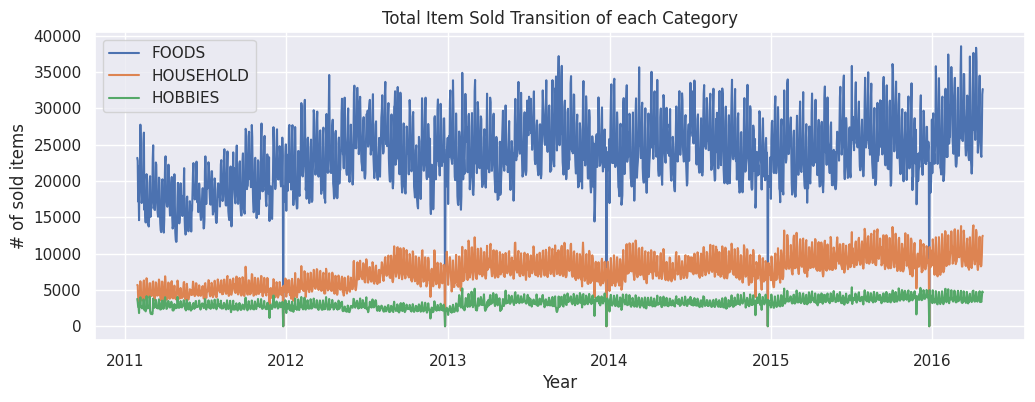

In [19]:
plt.figure(figsize=(12, 4))
plt.plot(temp_series[temp_series.index.get_level_values("cat_id") == "FOODS"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("cat_id") == "FOODS"].values, label="FOODS")
plt.plot(temp_series[temp_series.index.get_level_values("cat_id") == "HOUSEHOLD"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("cat_id") == "HOUSEHOLD"].values, label="HOUSEHOLD")
plt.plot(temp_series[temp_series.index.get_level_values("cat_id") == "HOBBIES"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("cat_id") == "HOBBIES"].values, label="HOBBIES")
plt.xlabel("Year")
plt.ylabel("# of sold items")
plt.title("Total Item Sold Transition of each Category")
plt.legend()

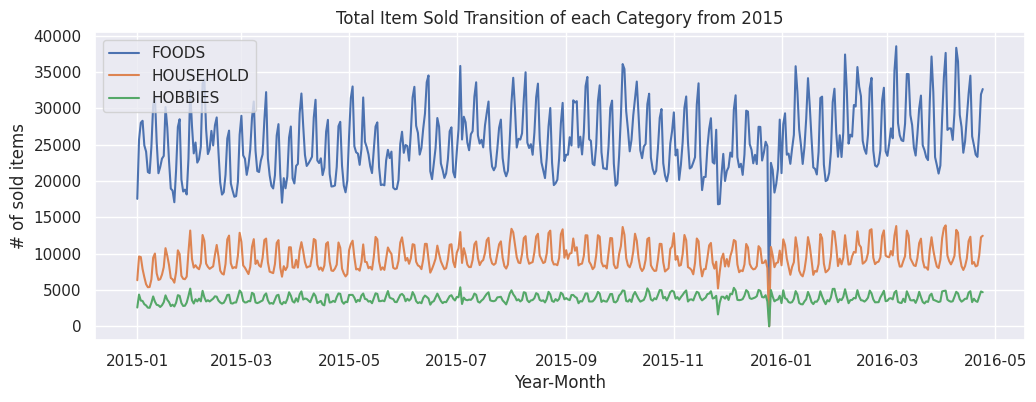

In [20]:
temp_series = temp_series.loc[temp_series.index.get_level_values("date") >= "2015-01-01"]
plt.figure(figsize=(12, 4))
plt.plot(temp_series[temp_series.index.get_level_values("cat_id") == "FOODS"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("cat_id") == "FOODS"].values, label="FOODS")
plt.plot(temp_series[temp_series.index.get_level_values("cat_id") == "HOUSEHOLD"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("cat_id") == "HOUSEHOLD"].values, label="HOUSEHOLD")
plt.plot(temp_series[temp_series.index.get_level_values("cat_id") == "HOBBIES"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("cat_id") == "HOBBIES"].values, label="HOBBIES")
plt.xlabel("Year-Month")
plt.ylabel("# of sold items")
plt.title("Total Item Sold Transition of each Category from 2015")
plt.legend()

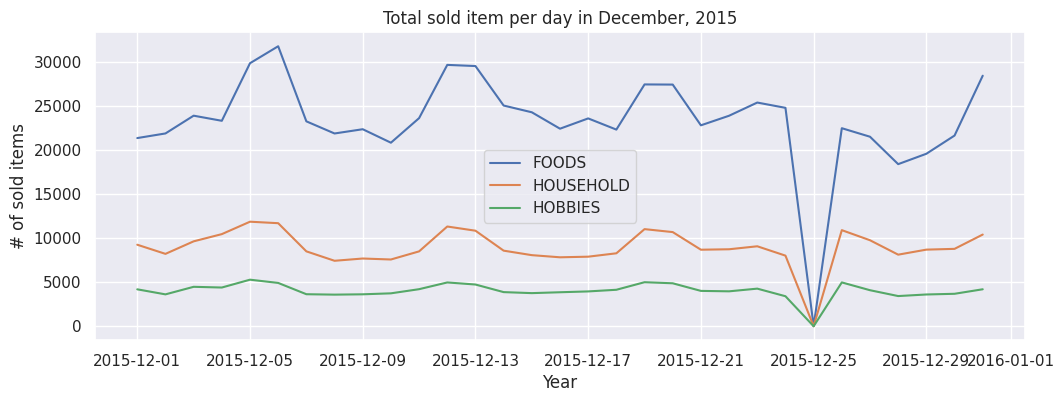

In [21]:
# Plot only December, 2015
temp_series = temp_series.loc[(temp_series.index.get_level_values("date") >= "2015-12-01") & (temp_series.index.get_level_values("date") <= "2015-12-31")]
plt.figure(figsize=(12, 4))
plt.plot(temp_series[temp_series.index.get_level_values("cat_id") == "FOODS"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("cat_id") == "FOODS"].values, label="FOODS")
plt.plot(temp_series[temp_series.index.get_level_values("cat_id") == "HOUSEHOLD"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("cat_id") == "HOUSEHOLD"].values, label="HOUSEHOLD")
plt.plot(temp_series[temp_series.index.get_level_values("cat_id") == "HOBBIES"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("cat_id") == "HOBBIES"].values, label="HOBBIES")
plt.xlabel("Year")
plt.ylabel("# of sold items")
plt.title("Total sold item per day in December, 2015")
plt.legend()

In [ ]:
temp_series.loc[(temp_series.index.get_level_values("date") >= "2015-12-24") & (temp_series.index.get_level_values("date") <= "2015-12-26")]

cat_id     date      
FOODS      2015-12-24    24801
           2015-12-25       13
           2015-12-26    22488
HOBBIES    2015-12-24     3408
           2015-12-25        0
           2015-12-26     4977
HOUSEHOLD  2015-12-24     8018
           2015-12-25        1
           2015-12-26    10912
Name: value, dtype: int32

### Item sold in each store of all states

In [ ]:
items_state_store = df.groupby(["state_id", "date"])["value"].sum()
items_state_store

state_id  date      
CA        2011-01-29    14195
          2011-01-30    13805
          2011-01-31    10108
          2011-02-01    11047
          2011-02-02     9925
                        ...  
WI        2016-04-20    10595
          2016-04-21    10943
          2016-04-22    12807
          2016-04-23    14862
          2016-04-24    14326
Name: value, Length: 5739, dtype: int32

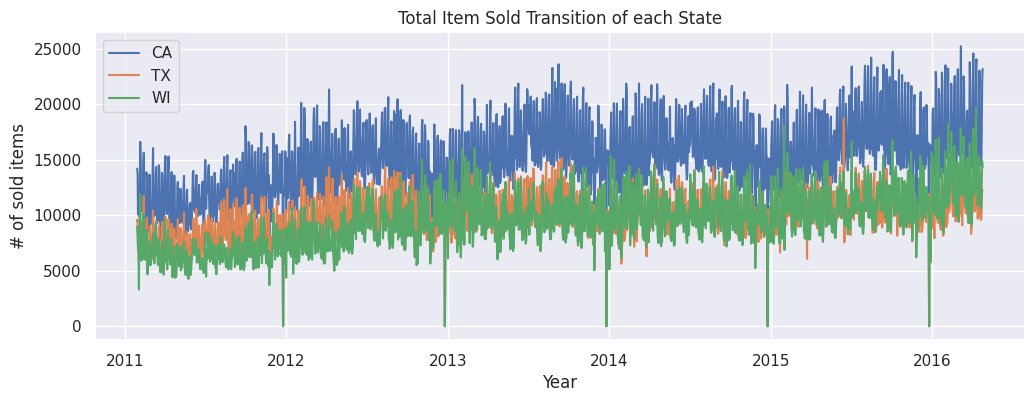

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(items_state_store[items_state_store.index.get_level_values("state_id") == "CA"].index.get_level_values("date"), items_state_store[items_state_store.index.get_level_values("state_id") == "CA"].values, label="CA")
plt.plot(items_state_store[items_state_store.index.get_level_values("state_id") == "TX"].index.get_level_values("date"), items_state_store[items_state_store.index.get_level_values("state_id") == "TX"].values, label="TX")
plt.plot(items_state_store[items_state_store.index.get_level_values("state_id") == "WI"].index.get_level_values("date"), items_state_store[items_state_store.index.get_level_values("state_id") == "WI"].values, label="WI")
plt.xlabel("Year")
plt.ylabel("# of sold items")
plt.title("Total Item Sold Transition of each State")
plt.legend()

CA is the most sold state of these three states.
let's have a look at stores in CA.

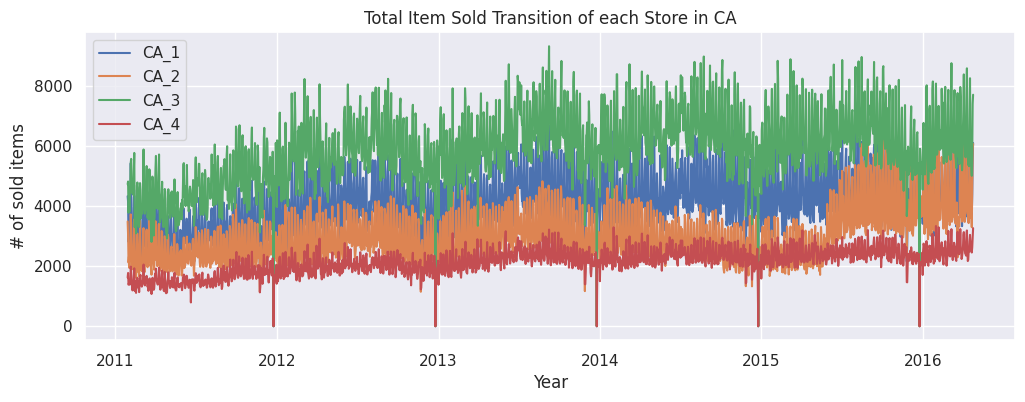

In [22]:
stores_sold_items = df.groupby(["store_id", "date"])["value"].sum()

plt.figure(figsize=(12, 4))
plt.plot(stores_sold_items[stores_sold_items.index.get_level_values("store_id") == "CA_1"].index.get_level_values("date"), stores_sold_items[stores_sold_items.index.get_level_values("store_id") == "CA_1"].values, label="CA_1")
plt.plot(stores_sold_items[stores_sold_items.index.get_level_values("store_id") == "CA_2"].index.get_level_values("date"), stores_sold_items[stores_sold_items.index.get_level_values("store_id") == "CA_2"].values, label="CA_2")
plt.plot(stores_sold_items[stores_sold_items.index.get_level_values("store_id") == "CA_3"].index.get_level_values("date"), stores_sold_items[stores_sold_items.index.get_level_values("store_id") == "CA_3"].values, label="CA_3")
plt.plot(stores_sold_items[stores_sold_items.index.get_level_values("store_id") == "CA_4"].index.get_level_values("date"), stores_sold_items[stores_sold_items.index.get_level_values("store_id") == "CA_4"].values, label="CA_4")

plt.xlabel("Year")
plt.ylabel("# of sold items")
plt.title("Total Item Sold Transition of each Store in CA")
plt.legend()


From around 2015 Spring or Summer, CA_2 increased its sold record rapidly. We have to investigate the reasons.


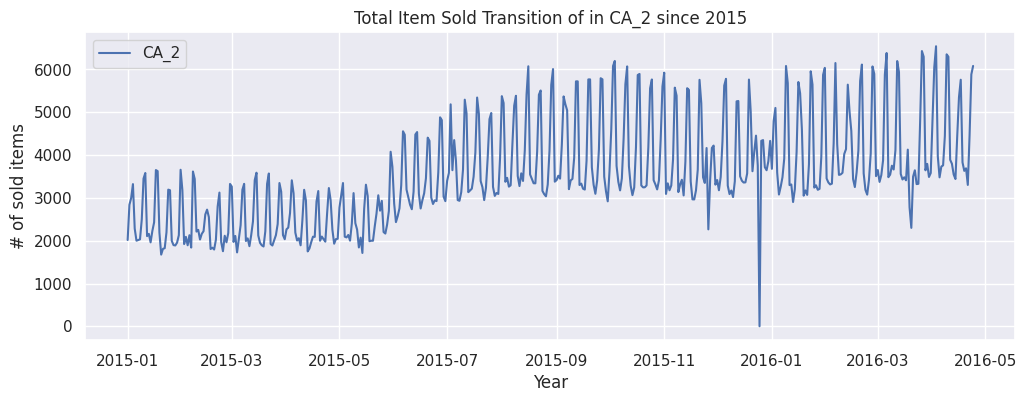

In [20]:
# Filter to select only data in 2015
CA_stores_sold_items_filtered = CA_stores_sold_items[CA_stores_sold_items.index.get_level_values("date") >= "2015-01-01"]

plt.figure(figsize=(12, 4))
plt.plot(CA_stores_sold_items_filtered[CA_stores_sold_items_filtered.index.get_level_values("store_id") == "CA_2"].index.get_level_values("date"), CA_stores_sold_items_filtered[CA_stores_sold_items_filtered.index.get_level_values("store_id") == "CA_2"].values, label="CA_2")


plt.xlabel("Year")
plt.ylabel("# of sold items")
plt.title("Total Item Sold Transition of in CA_2 since 2015")
plt.legend()


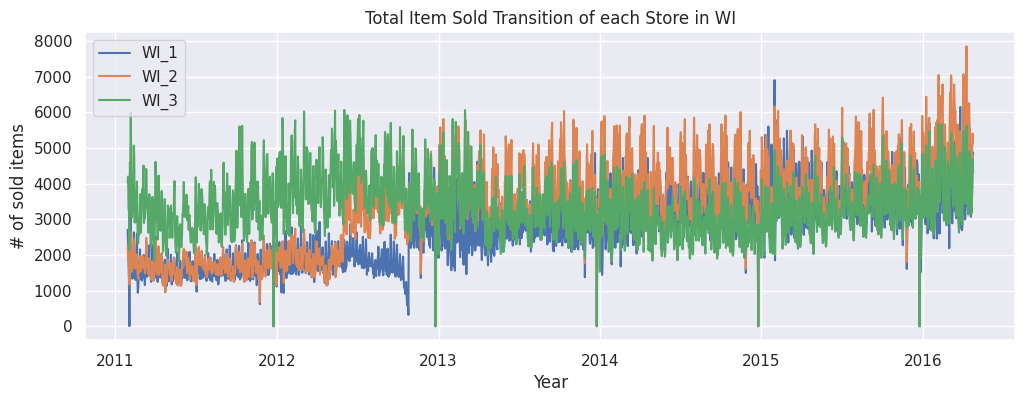

In [21]:
plt.figure(figsize=(12, 4))
plt.plot(stores_sold_items[stores_sold_items.index.get_level_values("store_id") == "WI_1"].index.get_level_values("date"), stores_sold_items[stores_sold_items.index.get_level_values("store_id") == "WI_1"].values, label="WI_1")
plt.plot(stores_sold_items[stores_sold_items.index.get_level_values("store_id") == "WI_2"].index.get_level_values("date"), stores_sold_items[stores_sold_items.index.get_level_values("store_id") == "WI_2"].values, label="WI_2")
plt.plot(stores_sold_items[stores_sold_items.index.get_level_values("store_id") == "WI_3"].index.get_level_values("date"), stores_sold_items[stores_sold_items.index.get_level_values("store_id") == "WI_3"].values, label="WI_3")

plt.xlabel("Year")
plt.ylabel("# of sold items")
plt.title("Total Item Sold Transition of each Store in WI")
plt.legend()


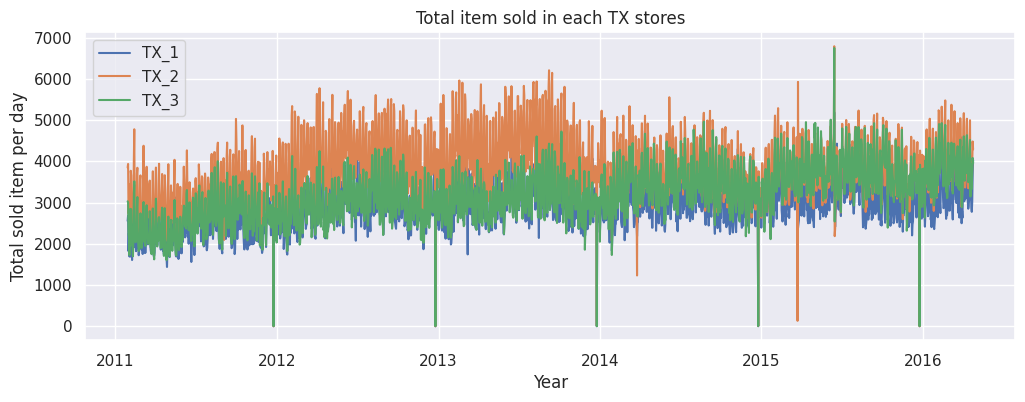

In [23]:
plt.figure(figsize=(12, 4))
plt.plot(stores_sold_items[stores_sold_items.index.get_level_values("store_id") == "TX_1"].index.get_level_values("date"), stores_sold_items[stores_sold_items.index.get_level_values("store_id") == "TX_1"].values, label="TX_1")
plt.plot(stores_sold_items[stores_sold_items.index.get_level_values("store_id") == "TX_2"].index.get_level_values("date"), stores_sold_items[stores_sold_items.index.get_level_values("store_id") == "TX_2"].values, label="TX_2")
plt.plot(stores_sold_items[stores_sold_items.index.get_level_values("store_id") == "TX_3"].index.get_level_values("date"), stores_sold_items[stores_sold_items.index.get_level_values("store_id") == "TX_3"].values, label="TX_3")
plt.xlabel("Year")
plt.ylabel("Total sold item per day")
plt.title("Total item sold in each TX stores")
plt.legend()

Text(0.5, 0.98, 'Each category item sold percentage in each store')

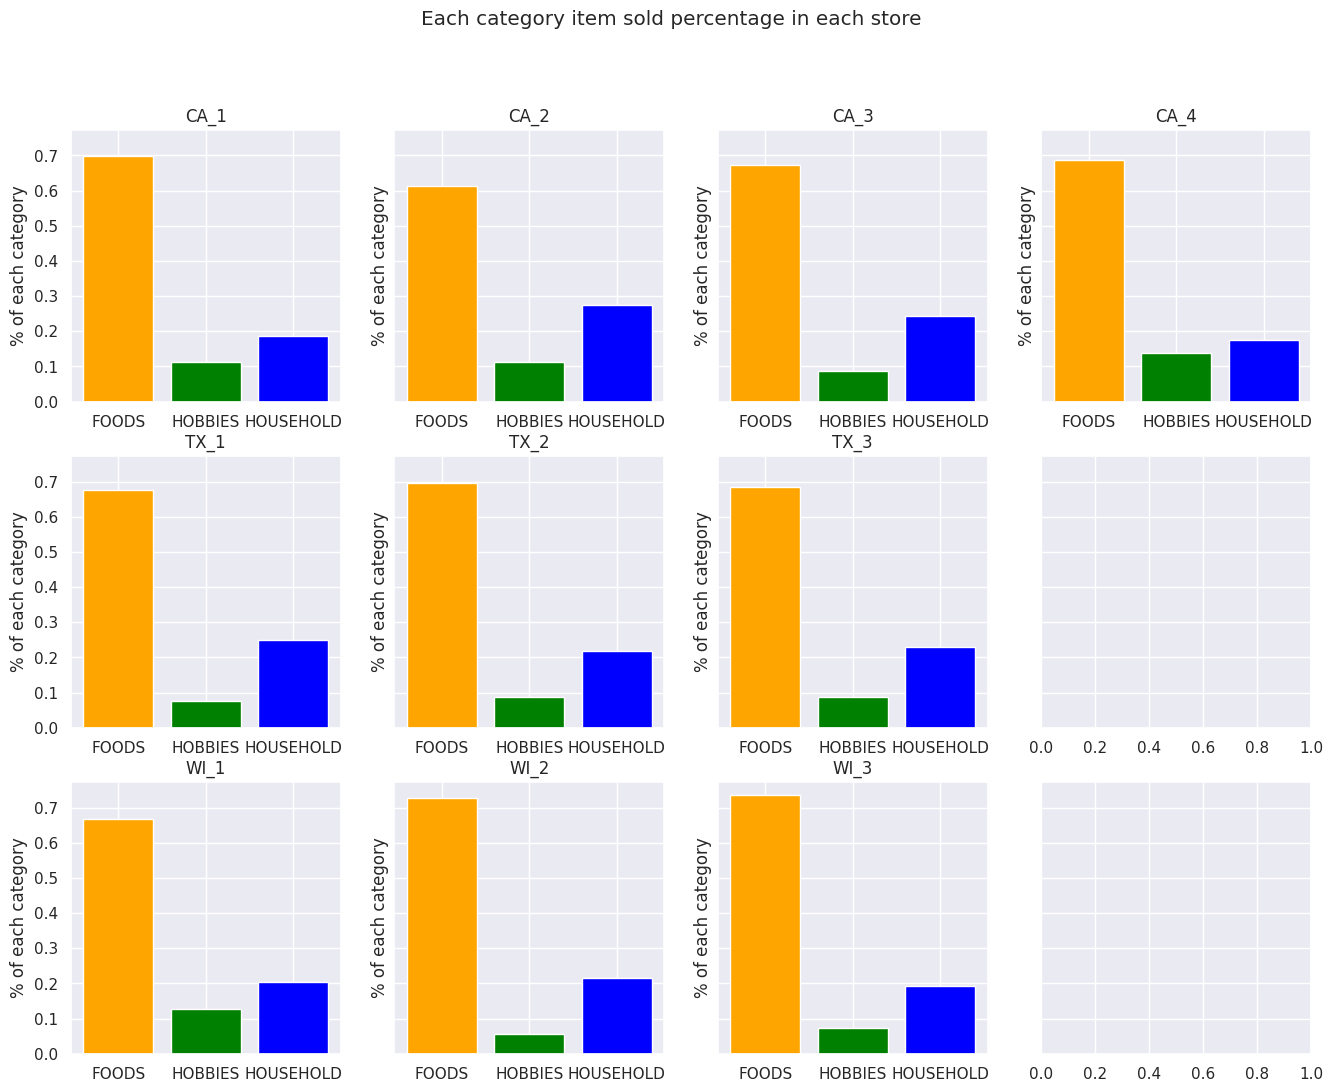

In [ ]:
store_category_solditems = df.groupby(["store_id", "cat_id"])["value"].sum()

store_id_list= [["CA_1", "CA_2", "CA_3", "CA_4"], ["TX_1", "TX_2", "TX_3"], ["WI_1", "WI_2", "WI_3"]]
fig, axs = plt.subplots(3, 4, figsize=(16, 12), sharey=True)
for row in range(len(store_id_list)):
    for col in range(len(store_id_list[row])):
        axs[row, col].bar(x=store_category_solditems[store_category_solditems.index.get_level_values("store_id") == store_id_list[row][col]].index.get_level_values("cat_id"),
                          height=store_category_solditems[store_category_solditems.index.get_level_values("store_id") == store_id_list[row][col]].values / store_category_solditems[store_category_solditems.index.get_level_values("store_id") == store_id_list[row][col]].sum(),
                         color=["orange", "green", "blue"], label=["FOODS", "HOBBIES", "HOUSEHOLD"])
        axs[row, col].set_title(store_id_list[row][col])
        axs[row, col].set_ylabel("% of each category")

fig.suptitle("Each category item sold percentage in each store")

## Sell Price Analysis

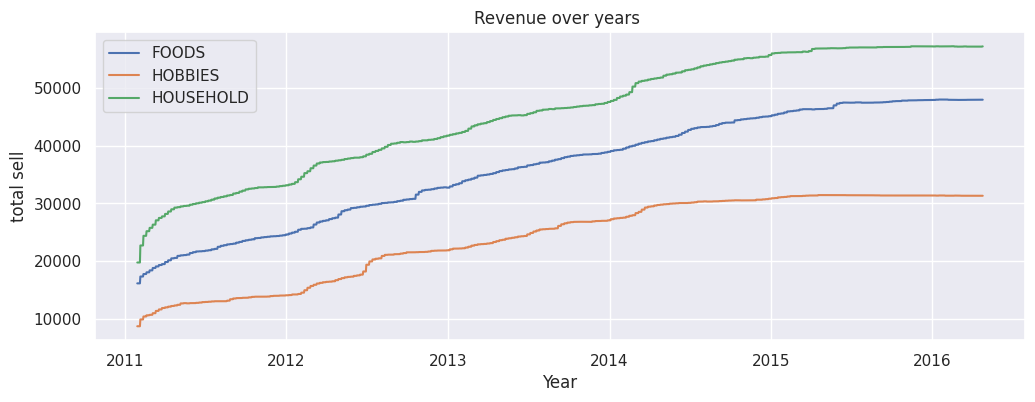

In [10]:
stores_sold_items = df.groupby(["cat_id", "date"])["sell_price"].sum()

plt.figure(figsize=(12, 4))
plt.plot(stores_sold_items[stores_sold_items.index.get_level_values("cat_id") == "FOODS"].index.get_level_values("date"), stores_sold_items[stores_sold_items.index.get_level_values("cat_id") == "FOODS"].values, label="FOODS")
plt.plot(stores_sold_items[stores_sold_items.index.get_level_values("cat_id") == "HOBBIES"].index.get_level_values("date"), stores_sold_items[stores_sold_items.index.get_level_values("cat_id") == "HOBBIES"].values, label="HOBBIES")
plt.plot(stores_sold_items[stores_sold_items.index.get_level_values("cat_id") == "HOUSEHOLD"].index.get_level_values("date"), stores_sold_items[stores_sold_items.index.get_level_values("cat_id") == "HOUSEHOLD"].values, label="HOUSEHOLD")

plt.xlabel("Year")
plt.ylabel("total sell")
plt.title("Revenue over years ")
plt.legend()


In [24]:
df.groupby("cat_id")["sell_price"].mean()


cat_id
FOODS        3.247233
HOBBIES      5.325491
HOUSEHOLD    5.465432
Name: sell_price, dtype: float32

In [25]:
df.groupby("cat_id")["sell_price"].describe()


,count,mean,std,min,25%,50%,75%,max
cat_id,,,,,,,,
FOODS,21395953.0,NaN,0.0,0.010002,1.980469,2.679688,3.970703,19.484375
HOBBIES,8642685.0,NaN,0.0,0.010002,1.969727,3.970703,7.468750,30.984375
HOUSEHOLD,15989319.0,NaN,0.0,0.010002,2.980469,4.941406,6.968750,107.312500


Text(0.5, 1.0, 'Boxplot of sell prices in each category')

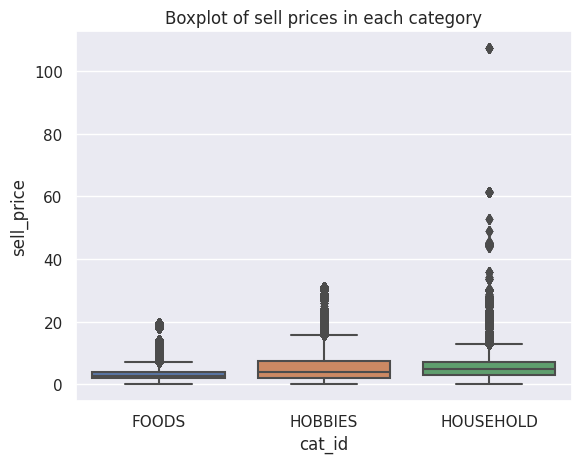

In [26]:
sns.boxplot(data=df, x="cat_id", y='sell_price')
plt.title("Boxplot of sell prices in each category")


Text(0.5, 1.0, 'Boxplot of sell prices in each store')

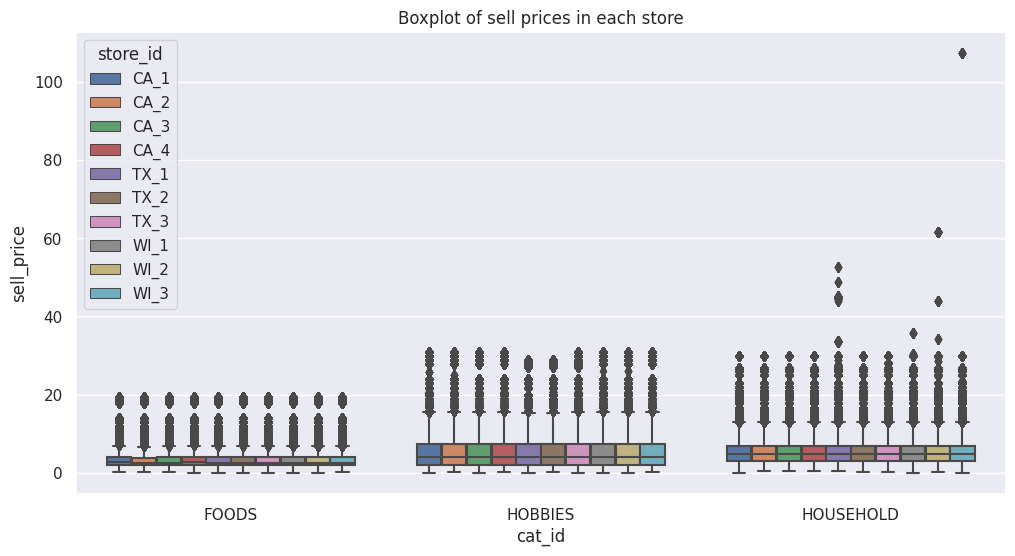

In [27]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="cat_id", y='sell_price', hue="store_id")
plt.title("Boxplot of sell prices in each store")

Text(0.5, 1.0, 'Mean price transition of each category')

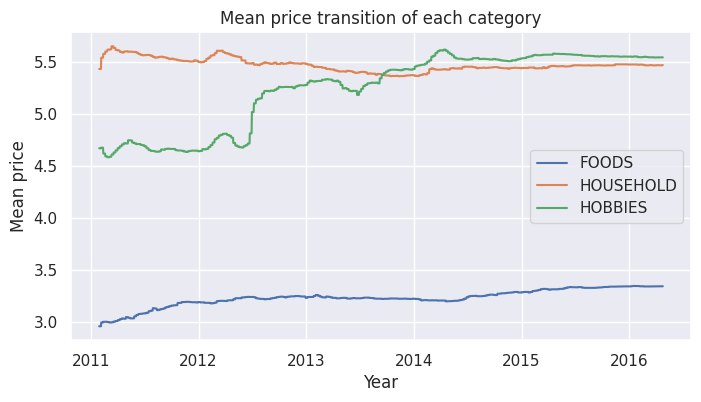

In [28]:
mean_price_cat = df.groupby(["date", "cat_id"])["sell_price"].mean()
plt.figure(figsize=(8,4))
sns.lineplot(x=mean_price_cat[mean_price_cat.index.get_level_values("cat_id") == "FOODS"].index.get_level_values("date"), y=mean_price_cat[mean_price_cat.index.get_level_values("cat_id") == "FOODS"].values, label="FOODS")
sns.lineplot(x=mean_price_cat[mean_price_cat.index.get_level_values("cat_id") == "HOUSEHOLD"].index.get_level_values("date"), y=mean_price_cat[mean_price_cat.index.get_level_values("cat_id") == "HOUSEHOLD"].values, label="HOUSEHOLD")
sns.lineplot(x=mean_price_cat[mean_price_cat.index.get_level_values("cat_id") == "HOBBIES"].index.get_level_values("date"), y=mean_price_cat[mean_price_cat.index.get_level_values("cat_id") == "HOBBIES"].values, label="HOBBIES")
plt.legend()
plt.xlabel("Year")
plt.ylabel("Mean price")
plt.title("Mean price transition of each category")


## Department Analysis


<ipython-input-12-19bc063c0403>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temp_df = df.groupby(["date", "cat_id", "dept_id"])["value", "sell_price"].mean()


Text(0.5, 0.98, 'Daily Average value - price plot and item count transition in each dept.')

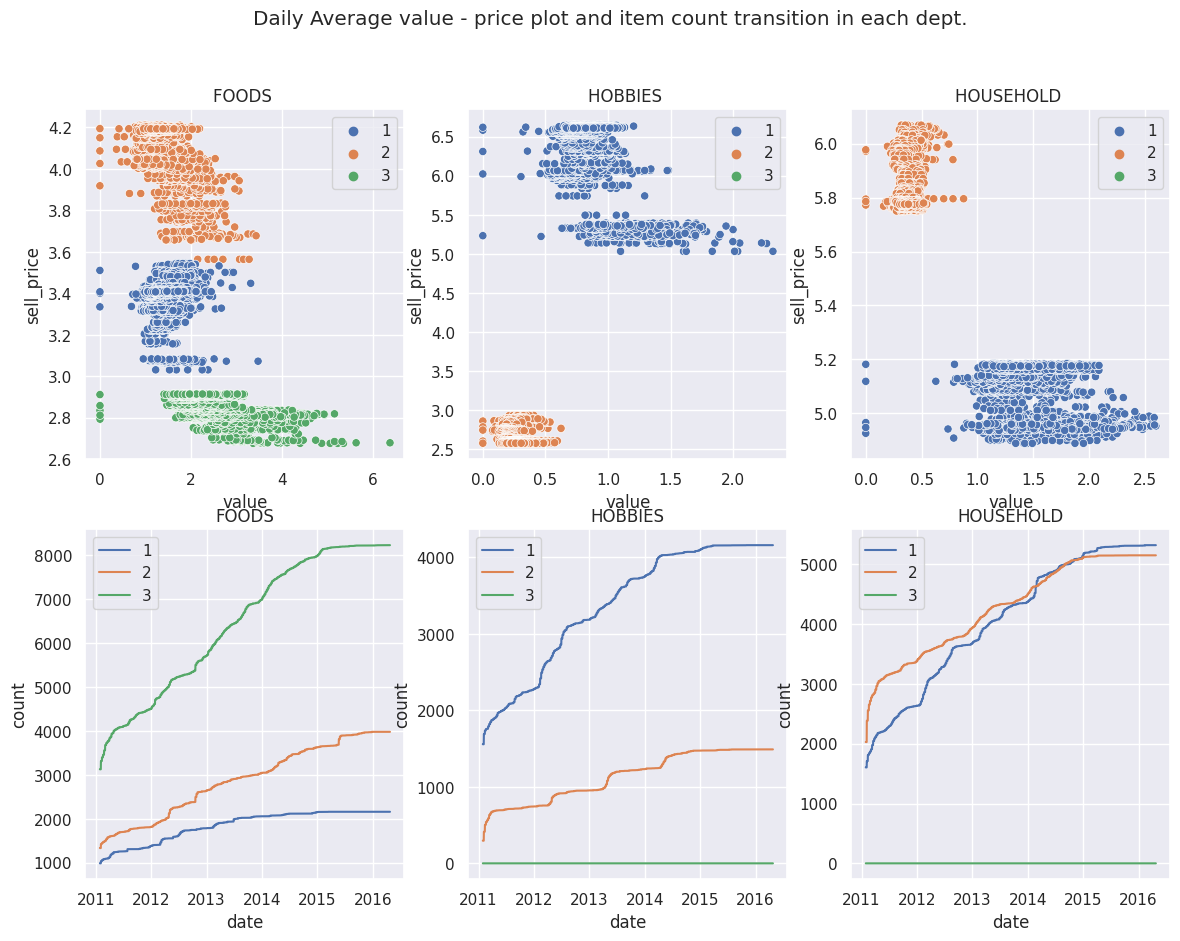

In [12]:
temp_df = df.groupby(["date", "cat_id", "dept_id"])["value", "sell_price"].mean()
cat_list=['FOODS','HOBBIES','HOUSEHOLD']
fig, axs = plt.subplots(2, 3, figsize=(14, 10))


for col in range(3):
    target_cat = cat_list[col]
    filtered_df = temp_df[temp_df.index.get_level_values("cat_id") == target_cat]

    sns.scatterplot(data=filtered_df, x="value", y="sell_price", hue=filtered_df.index.get_level_values("dept_id"), ax=axs[0, col])

#     axs[0, col].plot(temp_series[temp_series.index.get_level_values("item_id") == target_item].values)
    axs[0, col].set_title(f"{target_cat} ")
    axs[0, col].set_ylabel("sell_price")
    axs[0, col].set_xlabel("value")
#         axs[idx, col].set_xticks(temp_series[temp_series.index.get_level_values("item_id") == target_item].index.get_level_values("date"))
    axs[0, col].legend()

    temp_series = df[df["cat_id"] == target_cat].groupby(["date", "dept_id"])["item_id"].count()
    sns.lineplot(x=temp_series.index.get_level_values("date"), y=temp_series.values, hue=temp_series.index.get_level_values("dept_id"), ax=axs[1, col])
    axs[1, col].set_title(f"{target_cat}")
    axs[1, col].set_ylabel("count")
    axs[1, col].legend()

fig.suptitle("Daily Average value - price plot and item count transition in each dept.")

From these analysis, we can find the following things regarding department.

Common

Departments in each category are seemed to be classified by average sell price of its department.
FOODS

dept_3 has lower price and high volume plot compared to others.
In addition, dept_3 has more items than other departments.
HOBBIES

dept_1 has more items than dept_2
HOUSEHOLD

Unlike other categories, this category seemed that it doesn't have clear difference in each department.

## snap pusrchase


check disrtrubution of snap pusrchase over states


In [13]:
snap_purcahse_states = calendar_df.groupby(["year"])[["snap_CA", "snap_TX", "snap_WI"]].sum()
snap_purcahse_states

,snap_CA,snap_TX,snap_WI
year,,,
2011,110,110,110
2012,120,120,120
2013,120,120,120
2014,120,120,120
2015,120,120,120
2016,60,60,60


as we see it's the same over all states so lets visualize one state

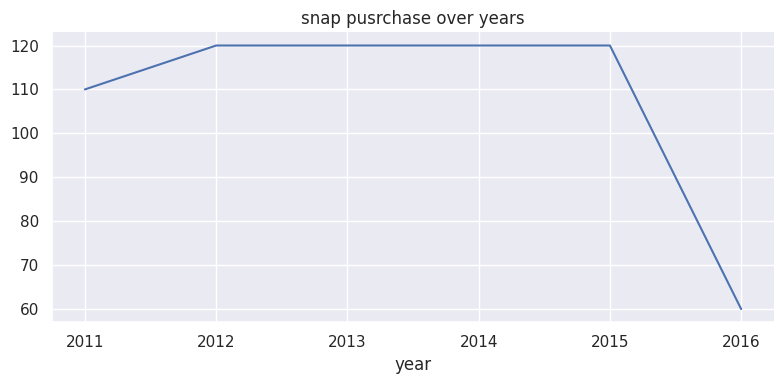

In [16]:
snap_purcahse_states['snap_CA'].plot(kind='line', figsize=(8 * 1, 4 * 1), title='snap pusrchase over years')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()

## most sold items of each category


In [30]:
# Group the DataFrame by 'cat_id'
grouped = df.groupby('cat_id')

# Initialize empty lists to store the results
max_item_ids = []
max_values = []

# Iterate through each group (category)
for cat, group in grouped:
    # Calculate the summation of 'number_of_sold_items' for each 'item_id' in the category
    item_sum = group.groupby('item_id')['value'].sum()

    # Find the 'item_id' with the maximum summation
    max_item_id = item_sum.idxmax()
    max_value = item_sum.max()

    # Append the results to the lists
    max_item_ids.append(max_item_id)
    max_values.append(max_value)

# Create a new DataFrame to store the results
result_df = pd.DataFrame({'cat_id': grouped.groups.keys(), 'max_item_id': max_item_ids, 'max_value': max_values})

# Print the result
print(result_df)


      cat_id      max_item_id  max_value
0      FOODS      FOODS_3_090    1002529
1    HOBBIES    HOBBIES_1_371     122565
2  HOUSEHOLD  HOUSEHOLD_1_334     171275


## Sell price and value relationship


<ipython-input-12-27196064aa7f>:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='sell_price', y='value', data=data, palette=[palette[i]])
<ipython-input-12-27196064aa7f>:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='sell_price', y='value', data=data, palette=[palette[i]])
<ipython-input-12-27196064aa7f>:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='sell_price', y='value', data=data, palette=[palette[i]])


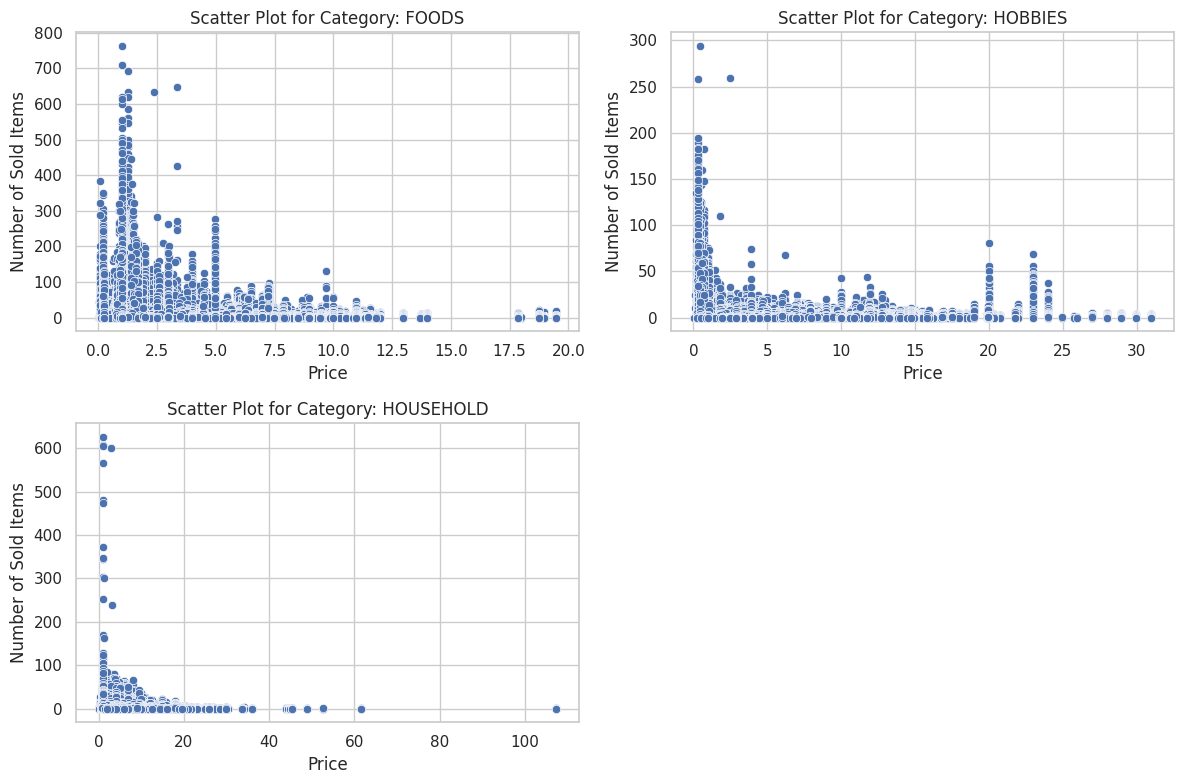

In [12]:
# Create a scatter plot for each category
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
palette = sns.color_palette("husl", len(df['cat_id'].unique()))

for i, (category, data) in enumerate(df.groupby('cat_id')):
    plt.subplot(2, 2, i + 1)
    sns.scatterplot(x='sell_price', y='value', data=data, palette=[palette[i]])
    plt.title(f'Scatter Plot for Category: {category}')
    plt.xlabel('Price')
    plt.ylabel('Number of Sold Items')

plt.tight_layout()
plt.show()
